<a href="https://colab.research.google.com/github/AArna1211/Traffic-prediction/blob/main/TP_VMD%2BCNN%2BLSTM%2BGRU_hybrid%2BXGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
!pip install vmdpy

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
from vmdpy import VMD
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, GRU, Flatten, Dense, Dropout, Concatenate, BatchNormalization, LayerNormalization, Attention
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.activations import swish
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from xgboost import XGBClassifier

In [97]:
data = pd.read_csv('/content/Traffic.csv')

In [98]:
data.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


In [99]:
data.sample(5)

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
2491,10:45:00 PM,4,Saturday,18,1,0,18,37,normal
970,2:30:00 AM,20,Friday,18,5,1,23,47,normal
1902,7:30:00 PM,29,Sunday,85,23,20,6,134,normal
2237,7:15:00 AM,2,Thursday,145,10,37,0,192,heavy
1151,11:45:00 PM,21,Sunday,10,2,1,15,28,normal


In [100]:
# Encode categorical "Traffic Situation"
label_encoder = LabelEncoder()
data["Traffic Situation Encoded"] = label_encoder.fit_transform(data["Traffic Situation"])

# Prepare features and labels
X = data[["CarCount", "BikeCount", "BusCount", "TruckCount", "Total"]].values
y = data["Traffic Situation Encoded"].values

In [101]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [102]:
# Apply Variational Mode Decomposition (VMD)
alpha = 2000      # moderate bandwidth constraint
tau = 0.          # noise-tolerance (no strict fidelity enforcement)
K = 3             # number of modes
DC = 0            # no DC part imposed
init = 1          # initialize modes randomly
tol = 1e-6        # tolerance

u, u_hat, omega = VMD(X[:, -1], alpha, tau, K, DC, init, tol)  # Decomposing only "Total" column
X_vmd = np.column_stack([u[i] for i in range(K)])

In [103]:
# Reshape input for time-series forecasting (sequence length = 5 for better long-term prediction)
sequence_length = 5
X_sequences = []
y_sequences = []
for i in range(len(X_vmd) - sequence_length):
    X_sequences.append(X_vmd[i:i + sequence_length])
    y_sequences.append(y[i + sequence_length])
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [104]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

In [105]:
# Define CNN branch
cnn_input = Input(shape=(sequence_length, K))
cnn_layer = Conv1D(filters=128, kernel_size=3, activation=swish)(cnn_input)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Conv1D(filters=64, kernel_size=3, activation=swish)(cnn_layer)
cnn_layer = Conv1D(filters=32, kernel_size=1, activation=swish)(cnn_layer)
cnn_layer = Flatten()(cnn_layer)

In [106]:
# Define Bi-LSTM branch with added complexity
lstm_input = Input(shape=(sequence_length, K))
lstm_layer = LSTM(128, return_sequences=True)(lstm_input)
lstm_layer = BatchNormalization()(lstm_layer)
lstm_layer = LSTM(64, return_sequences=True)(lstm_layer)
lstm_layer = LSTM(32, return_sequences=True)(lstm_layer)
lstm_layer = LSTM(16, return_sequences=True)(lstm_layer)  # Ensure output is 3D

In [107]:
# Define GRU branch with extra complexity
gru_input = Input(shape=(sequence_length, K))
gru_layer = GRU(128, return_sequences=True)(gru_input)
gru_layer = BatchNormalization()(gru_layer)
gru_layer = GRU(64, return_sequences=True)(gru_layer)
gru_layer = GRU(32, return_sequences=True)(gru_layer)
gru_layer = GRU(16, return_sequences=True)(gru_layer)  # Ensure output is 3D


In [108]:
# Attention Mechanism (Fix Shape Mismatch)
attention_output = Attention()([lstm_layer, gru_layer])
attention_output = Flatten()(attention_output)  # Flatten to match Dense layer input


In [109]:
# Merge layers
# Flatten lstm_layer and gru_layer before concatenation
merged = Concatenate()([cnn_layer, Flatten()(lstm_layer), Flatten()(gru_layer), attention_output])
final_layer = Dense(128, activation=swish, kernel_regularizer=l2(0.001))(merged)
final_layer = Dropout(0.6)(final_layer)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(final_layer)

In [110]:
# Define model
model = Model(inputs=[cnn_input, lstm_input, gru_input], outputs=output_layer)
model.compile(optimizer=AdamW(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [111]:
# Implement Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-5)

In [112]:
# Train model
history = model.fit([X_train, X_train, X_train], y_train, epochs=60, batch_size=6, validation_data=([X_test, X_test, X_test], y_test), verbose=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/60
396/396 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.6242 - loss: 1.1394 - val_accuracy: 0.5866 - val_loss: 1.0807 - learning_rate: 5.0000e-04
Epoch 2/60
396/396 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.7305 - loss: 0.8905 - val_accuracy: 0.7261 - val_loss: 0.8467 - learning_rate: 5.0000e-04
Epoch 3/60
396/396 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.7489 - loss: 0.8183 - val_accuracy: 0.7345 - val_loss: 0.7965 - learning_rate: 5.0000e-04
Epoch 4/60
396/396 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.7461 - loss: 0.8106 - val_accuracy: 0.7345 - val_loss: 0.8226 - learning_rate: 5.0000e-04
Epoch 5/60
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7357 - loss: 0.8091 - val_accuracy: 0.7445 - val_loss: 0.7474 - learning_rate: 5.0000e-04
Epoch 6/60
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.7698 - loss: 0.6945 - val_accuracy: 0.7378 - val_loss: 0.7519 - learning_rate: 5.0000e-04
Epoch 7/60
396/396 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step

In [113]:
# Extract deep features
deep_features = model.predict([X_train, X_train, X_train])

# Train XGBoost on deep features
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb.fit(deep_features, y_train)

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test Accuracy: 0.7143
Mean Absolute Error: 0.4605


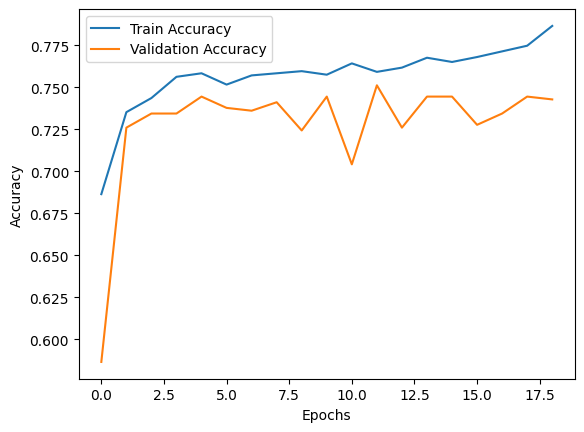

In [114]:
# Evaluate ensemble model
deep_features_test = model.predict([X_test, X_test, X_test])
y_pred = xgb.predict(deep_features_test)
accuracy = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()